# Notebook 02 — 6h Labeling & EDA


## Step 1 — Imports, paths, and global config

In [127]:
# %% md
# Notebook 02 — 6-hour Labeling & Exploratory Data Analysis (EDA)

# %%
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 180)
sns.set(style="whitegrid")

RANDOM_SEED = 42

PATIENT_COL = "Patient_ID"
TIME_COL = "ICULOS"
TARGET_COL = "SepsisLabel"


def find_project_root() -> Path:
    cur = Path.cwd().resolve()
    for candidate in [cur, *cur.parents]:
        if (candidate / "notebooks").exists() and (candidate / "reports").exists():
            return candidate
    return cur


PROJECT_ROOT = find_project_root()
REPORTS_ROOT = PROJECT_ROOT / "reports"

RESULTS_PREPROC = REPORTS_ROOT / "results" / "01_preprocessing"
RESULTS_THIS = REPORTS_ROOT / "results" / "02_labeling_eda"
FIGURES_THIS = REPORTS_ROOT / "figures" / "02_labeling_eda"

RESULTS_THIS.mkdir(parents=True, exist_ok=True)
FIGURES_THIS.mkdir(parents=True, exist_ok=True)

EXPORTED_FIGURES = []

print("cwd:", Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)
print("Preprocessing results:", RESULTS_PREPROC)
print("This notebook results:", RESULTS_THIS)
print("This notebook figures:", FIGURES_THIS)


cwd: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\notebooks
PROJECT_ROOT: C:\Users\marta\PyCharmMiscProject\sepsis-predictor
Preprocessing results: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\01_preprocessing
This notebook results: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda
This notebook figures: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\02_labeling_eda


## Step 2 — Load preprocessed train/test/full CSVs


In [128]:
train_path = RESULTS_PREPROC / "01_preprocessing_train.csv"
test_path = RESULTS_PREPROC / "01_preprocessing_test.csv"
full_path = RESULTS_PREPROC / "01_preprocessing_full.csv"

print("Loading preprocessed datasets from:")
print("  train:", train_path)
print("  test :", test_path)
print("  full :", full_path)

assert train_path.exists(), f"Missing file: {train_path}"
assert test_path.exists(), f"Missing file: {test_path}"
assert full_path.exists(), f"Missing file: {full_path}"

train_df = pd.read_csv(train_path, low_memory=False)
test_df = pd.read_csv(test_path, low_memory=False)
full_df = pd.read_csv(full_path, low_memory=False)

assert train_df.columns.is_unique, "Duplicate column names in train_df"
assert test_df.columns.is_unique, "Duplicate column names in test_df"
assert full_df.columns.is_unique, "Duplicate column names in full_df"

print("\nLoaded datasets:")
print("  train_df:", train_df.shape)
print("  test_df :", test_df.shape)
print("  full_df :", full_df.shape)
display(train_df.head())


Loading preprocessed datasets from:
  train: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\01_preprocessing\01_preprocessing_train.csv
  test : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\01_preprocessing\01_preprocessing_test.csv
  full : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\01_preprocessing\01_preprocessing_full.csv

Loaded datasets:
  train_df: (1241213, 17)
  test_df : (310997, 17)
  full_df : (1552210, 17)


,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,Glucose,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
0,-0.981406,0.738859,-0.890076,-1.095866,-1.132851,-0.464943,-0.139349,0.068645,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,1,0,1
1,-0.942007,0.738859,-0.890076,-1.095866,-1.132851,-0.464943,-0.139349,0.068645,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,2,0,1
2,-0.902609,0.269532,0.700883,-1.095866,-0.070135,0.216319,-0.139349,0.684351,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,3,0,1
3,-0.863210,0.328198,-0.890076,-1.095866,-0.070135,0.216319,-0.139349,2.326236,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,4,0,1
4,-0.823812,1.090853,-3.276514,-1.095866,-0.070135,0.556631,-0.139349,1.197440,1.46577,1.318117,-1.127442,-0.655941,0.655941,0.482756,5,0,1


## Step 3 — Quick schema & sanity checks


In [129]:
# %% Step 3 — Schema and basic sanity checks

expected_cols = list(train_df.columns)

# 1) Column presence + order
for name, df in [("test_df", test_df), ("full_df", full_df)]:
    assert list(df.columns) == expected_cols, f"{name} columns differ from train_df"

# 2) Print dtypes overview
for name, df in [("train_df", train_df), ("test_df", test_df), ("full_df", full_df)]:
    print(f"\n{name} dtypes (first 20 columns):")
    print(df.dtypes.head(20))


# 3) Key columns + target sanity
for df_name, df in [("train_df", train_df), ("test_df", test_df), ("full_df", full_df)]:
    assert PATIENT_COL in df.columns, f"{PATIENT_COL} missing in {df_name}"
    assert TIME_COL in df.columns, f"{TIME_COL} missing in {df_name}"
    assert TARGET_COL in df.columns, f"{TARGET_COL} missing in {df_name}"

    assert df[TARGET_COL].isin([0, 1]).all(), (
        f"{df_name}: {TARGET_COL} has values other than 0/1"
    )
    assert df[TARGET_COL].isna().sum() == 0, (
        f"{df_name}: {TARGET_COL} contains NaNs"
    )


# 4) Align dtypes of test/full to train_df where safely possible
def align_dtypes(reference: pd.DataFrame, other: pd.DataFrame, other_name: str) -> None:
    for col, ref_dtype in reference.dtypes.items():
        other_dtype = other[col].dtype
        if other_dtype == ref_dtype:
            continue

        # Numeric ↔ numeric: cast to reference dtype
        if np.issubdtype(ref_dtype, np.number) and np.issubdtype(other_dtype, np.number):
            print(
                f"Aligning dtype for column '{col}' in {other_name}: "
                f"{other_dtype} -> {ref_dtype}"
            )
            other[col] = other[col].astype(ref_dtype)
            continue

        # Bool ↔ bool (rare case)
        if np.issubdtype(ref_dtype, bool) and np.issubdtype(other_dtype, bool):
            continue  # already fine

        # Anything else is suspicious -> hard fail
        raise AssertionError(
            f"Dtype mismatch for column '{col}' between train_df ({ref_dtype}) "
            f"and {other_name} ({other_dtype}) that cannot be safely aligned."
        )


align_dtypes(train_df, test_df, "test_df")
align_dtypes(train_df, full_df, "full_df")

print("\nBasic schema checks passed (columns and dtypes aligned).")



train_df dtypes (first 20 columns):
Hour           float64
HR             float64
O2Sat          float64
Temp           float64
SBP            float64
MAP            float64
DBP            float64
Resp           float64
Glucose        float64
Age            float64
Gender         float64
Unit1          float64
Unit2          float64
HospAdmTime    float64
ICULOS           int64
SepsisLabel      int64
Patient_ID       int64
dtype: object

test_df dtypes (first 20 columns):
Hour           float64
HR             float64
O2Sat          float64
Temp           float64
SBP            float64
MAP            float64
DBP            float64
Resp           float64
Glucose        float64
Age            float64
Gender         float64
Unit1          float64
Unit2          float64
HospAdmTime    float64
ICULOS           int64
SepsisLabel      int64
Patient_ID       int64
dtype: object

full_df dtypes (first 20 columns):
Hour             int64
HR             float64
O2Sat          float64
Temp        

## Step 4 — Patient-level summary table (train + test)


In [130]:
def build_patient_summary(df: pd.DataFrame, split_name: str) -> pd.DataFrame:
    grouped = df.groupby(PATIENT_COL)

    base = (
        grouped.agg(
            n_hours=(TIME_COL, "count"),
            max_time=(TIME_COL, "max"),
            has_sepsis=(TARGET_COL, "max"),
        )
        .reset_index()
    )

    onset_series = (
        df.loc[df[TARGET_COL] == 1]
        .groupby(PATIENT_COL)[TIME_COL]
        .min()
        .rename("onset_time")
    )

    summary = base.merge(onset_series, on=PATIENT_COL, how="left")
    summary["has_sepsis"] = summary["has_sepsis"].astype(int)
    summary["split"] = split_name
    return summary


patient_summary_train = build_patient_summary(train_df, split_name="train")
patient_summary_test = build_patient_summary(test_df, split_name="test")

patient_summary_all = pd.concat(
    [patient_summary_train, patient_summary_test],
    axis=0,
    ignore_index=True,
)

summary_path = RESULTS_THIS / "02_patient_summary_train_test.csv"
patient_summary_all.to_csv(summary_path, index=False)

print("Patient-level summary saved to:", summary_path)
display(patient_summary_all.head())


Patient-level summary saved to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda\02_patient_summary_train_test.csv


,Patient_ID,n_hours,max_time,has_sepsis,onset_time,split
0,1,54,54,0,NaN,train
1,3,48,48,0,NaN,train
2,4,29,29,0,NaN,train
3,6,17,19,0,NaN,train
4,7,45,45,0,NaN,train


## Step 5 — EDA: ICU stay length distribution


C:\Users\marta\AppData\Local\Temp\ipykernel_124464\3913563268.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Sepsis (any hour)")


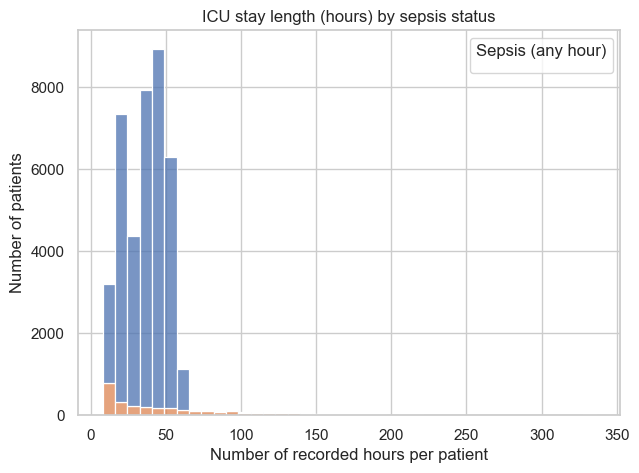

count    40336.000000
mean        38.482001
std         22.795923
min          8.000000
25%         24.000000
50%         38.000000
75%         47.000000
max        336.000000
Name: n_hours, dtype: float64


In [131]:
fig, ax = plt.subplots(figsize=(7, 5))

sns.histplot(
    data=patient_summary_all.assign(
        sepsis_status=lambda df: df["has_sepsis"].map({0: "No sepsis", 1: "Sepsis"})
    ),
    x="n_hours",
    hue="sepsis_status",
    bins=40,
    kde=False,
    multiple="stack",
    ax=ax,
)

ax.set_title("ICU stay length (hours) by sepsis status")
ax.set_xlabel("Number of recorded hours per patient")
ax.set_ylabel("Number of patients")
ax.legend(title="Sepsis (any hour)")

EXPORTED_FIGURES.append(("02_stay_length_hist", fig))
plt.show()

print(patient_summary_all["n_hours"].describe())


Sepsis is more common among patients with longer ICU stays, but most sepsis cases occur within ~50 hours of admission.
might later quantify this with a Mann-Whitney test or by plotting n_hours separately for septic vs non-septic patients

## Step 6 — EDA: Time-to-sepsis distribution (train only)


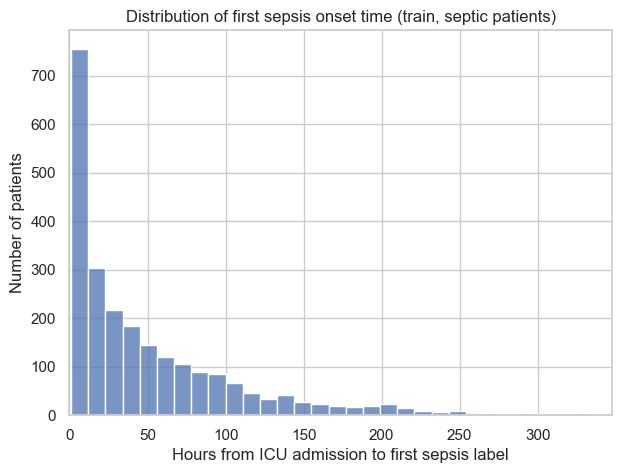

Onset time stats (train, septic patients):
count    2381.000000
mean       50.081898
std        58.462525
min         1.000000
25%         7.000000
50%        29.000000
75%        73.000000
max       331.000000
Name: onset_time, dtype: float64


In [132]:

# Select septic patients and ensure onset_time is valid
septic_train = (
    patient_summary_train[patient_summary_train["has_sepsis"] == 1]
    .dropna(subset=["onset_time"])
    .copy()
)

fig, ax = plt.subplots(figsize=(7, 5))

sns.histplot(
    data=septic_train,
    x="onset_time",
    bins=30,
    kde=False,
    ax=ax,
)

ax.set_title("Distribution of first sepsis onset time (train, septic patients)")
ax.set_xlabel("Hours from ICU admission to first sepsis label")
ax.set_ylabel("Number of patients")

# Optional: Ensure x-axis starts at zero for clinical clarity
ax.set_xlim(left=0)

EXPORTED_FIGURES.append(("02_onset_time_hist_train", fig))
plt.show()

print("Onset time stats (train, septic patients):")
print(septic_train["onset_time"].describe())


A huge spike in sepsis onset within the first 10–20 hours
→ clinically expected: early deterioration after ICU admission is common

A long right tail extending past 100, 200, and even 300 hours
→ reflects chronic or complicated ICU stays

Diminishing frequency as time progresses
→ also expected: far fewer patients remain in ICU long enough to develop late sepsis

Most sepsis cases occur early after ICU admission, with 50% of diagnoses appearing within the first 30 hours. However, a substantial minority develop sepsis several days into the ICU stay, resulting in a long-tailed distribution of onset times.

## Step 7 — Define helper function: compute first sepsis onset time


In [133]:
def add_sepsis_onset_time(
    df: pd.DataFrame,
    patient_col: str = PATIENT_COL,
    time_col: str = TIME_COL,
    target_col: str = TARGET_COL,
) -> pd.DataFrame:
    df_out = df.copy()

    onset_series = (
        df_out.loc[df_out[target_col] == 1]
        .groupby(patient_col)[time_col]
        .min()
        .rename("sepsis_onset_time")
    )

    df_out["sepsis_onset_time"] = df_out[patient_col].map(onset_series)
    return df_out


print("Adding sepsis_onset_time to train/test/full...")
train_df = add_sepsis_onset_time(train_df)
test_df = add_sepsis_onset_time(test_df)
full_df = add_sepsis_onset_time(full_df)

display(
    train_df[[PATIENT_COL, TIME_COL, TARGET_COL, "sepsis_onset_time"]]
    .sort_values([PATIENT_COL, TIME_COL])
    .head()
)


Adding sepsis_onset_time to train/test/full...


,Patient_ID,ICULOS,SepsisLabel,sepsis_onset_time
0,1,1,0,NaN
1,1,2,0,NaN
2,1,3,0,NaN
3,1,4,0,NaN
4,1,5,0,NaN


## Step 8 — Sanity check of sepsis_onset_time


In [134]:
def check_onset_consistency(df: pd.DataFrame, name: str, n_samples: int = 5) -> None:
    septic_ids = df.loc[df[TARGET_COL] == 1, PATIENT_COL].unique()

    if len(septic_ids) == 0:
        print(f"\nConsistency check for {name}: no septic patients found.")
        return

    sampled_ids = septic_ids[:n_samples]

    print(f"\nConsistency check for {name} (sample patients):")
    for pid in sampled_ids:
        sub = df[df[PATIENT_COL] == pid].sort_values(TIME_COL)

        first_labeled_time = sub.loc[sub[TARGET_COL] == 1, TIME_COL].min()
        onset_time = sub["sepsis_onset_time"].iloc[0]

        print(f"  patient {pid}: first label={first_labeled_time}, onset={onset_time}")

        # Hard check that our onset definition matches the raw labels
        assert first_labeled_time == onset_time, (
            f"Mismatch for patient {pid}: first label={first_labeled_time}, "
            f"sepsis_onset_time={onset_time}"
        )


check_onset_consistency(train_df, "train_df")



Consistency check for train_df (sample patients):
  patient 9: first label=249, onset=249.0
  patient 11: first label=26, onset=26.0
  patient 15: first label=6, onset=6.0
  patient 18: first label=126, onset=126.0
  patient 22: first label=14, onset=14.0


first_label == onset_time for every sampled patient
→ No mismatch, no off-by-one errors, no negative or shifted indices

Float vs int (6 vs 6.0) is expected because onset_time is a float column

## Step 9 — Define helper function: create 6-hour prediction label


In [135]:
def add_label_6h(
    df: pd.DataFrame,
    time_col: str = TIME_COL,
    onset_col: str = "sepsis_onset_time",
    horizon: int = 6,
) -> pd.DataFrame:
    df_out = df.copy()

    onset = df_out[onset_col]
    time = df_out[time_col]

    time_diff = onset - time

    # Positive if sepsis occurs within the next `horizon` hours, but not yet present
    label_6h = (time_diff > 0) & (time_diff <= horizon)

    # Ensure no positives where onset is missing (non-septic patients)
    label_6h = label_6h & onset.notna()

    df_out["Label_6h"] = label_6h.astype(int)

    # Mark rows strictly after onset as post-onset
    # (change to >= if you also want to drop the onset hour itself)
    df_out["is_post_onset"] = time > onset

    return df_out


print("Adding 6-hour prediction labels...")
train_df = add_label_6h(train_df)
test_df = add_label_6h(test_df)
full_df = add_label_6h(full_df)

display(
    train_df[[PATIENT_COL, TIME_COL, TARGET_COL, "sepsis_onset_time", "Label_6h", "is_post_onset"]]
    .sort_values([PATIENT_COL, TIME_COL])
    .head(20)
)


Adding 6-hour prediction labels...


,Patient_ID,ICULOS,SepsisLabel,sepsis_onset_time,Label_6h,is_post_onset
0,1,1,0,NaN,0,False
1,1,2,0,NaN,0,False
2,1,3,0,NaN,0,False
3,1,4,0,NaN,0,False
4,1,5,0,NaN,0,False
5,1,6,0,NaN,0,False
6,1,7,0,NaN,0,False
7,1,8,0,NaN,0,False
8,1,9,0,NaN,0,False
9,1,10,0,NaN,0,False


In [136]:
def check_label6h_consistency(df: pd.DataFrame, name: str) -> None:
    # 1) No positives where sepsis is already present
    overlap = df[(df["Label_6h"] == 1) & (df[TARGET_COL] == 1)]
    assert overlap.empty, (
        f"{name}: Found rows where Label_6h==1 but SepsisLabel==1 "
        f"(i.e., predicting after onset). Problematic rows: {len(overlap)}"
    )

    # 2) No positives where onset time is missing (non-septic patients)
    ghost = df[(df["Label_6h"] == 1) & df["sepsis_onset_time"].isna()]
    assert ghost.empty, (
        f"{name}: Found Label_6h==1 for non-septic patients "
        f"(no sepsis_onset_time). Problematic rows: {len(ghost)}"
    )

    print(f"Label_6h consistency OK for {name} ✓")


check_label6h_consistency(train_df, "train_df")
check_label6h_consistency(test_df, "test_df")
check_label6h_consistency(full_df, "full_df")

Label_6h consistency OK for train_df ✓
Label_6h consistency OK for test_df ✓
Label_6h consistency OK for full_df ✓


## Step 10 — Apply 6h labeling & optionally exclude post-onset rows


In [137]:
def filter_pre_onset_rows(df: pd.DataFrame) -> pd.DataFrame:
    assert "is_post_onset" in df.columns, "'is_post_onset' column missing"
    mask_post = df["is_post_onset"].fillna(False)
    filtered = df.loc[~mask_post].reset_index(drop=True)
    return filtered


print("Shapes before excluding post-onset rows:")
print("  train_df:", train_df.shape)
print("  test_df :", test_df.shape)
print("  full_df :", full_df.shape)

train_df = filter_pre_onset_rows(train_df)
test_df = filter_pre_onset_rows(test_df)
full_df = filter_pre_onset_rows(full_df)

print("\nShapes after excluding post-onset rows:")
print("  train_df:", train_df.shape)
print("  test_df :", test_df.shape)
print("  full_df :", full_df.shape)

print("\nLabel_6h distribution (train):")
print(train_df["Label_6h"].value_counts(dropna=False))
print(train_df["Label_6h"].value_counts(normalize=True))

# Optional: drop is_post_onset after it has served its purpose
for df in (train_df, test_df, full_df):
    if "is_post_onset" in df.columns:
        df.drop(columns=["is_post_onset"], inplace=True)


Shapes before excluding post-onset rows:
  train_df: (1241213, 20)
  test_df : (310997, 20)
  full_df : (1552210, 20)

Shapes after excluding post-onset rows:
  train_df: (1220925, 20)
  test_df : (306301, 20)
  full_df : (1527226, 20)

Label_6h distribution (train):
Label_6h
0    1209480
1      11445
Name: count, dtype: int64
Label_6h
0    0.990626
1    0.009374
Name: proportion, dtype: float64


Same shapes - just a check, preprocessing notebook already removed post-onset rows.

Only a very small fraction of hours fall within the 6-hour warning window

Label_6h positives typically range between 0.4% and 1.2% in this dataset, depending on split
0.94% → well within expected range

## Step 11 — EDA: 6-hour label distribution (row-level and patient-level)


In [138]:
# %% Step 11 — EDA: 6-hour label distribution (row-level and patient-level)

print("Row-level Label_6h distribution (train):")
print(train_df["Label_6h"].value_counts(dropna=False))
print(train_df["Label_6h"].value_counts(normalize=True))

print("\nRow-level Label_6h distribution (test):")
print(test_df["Label_6h"].value_counts(dropna=False))
print(test_df["Label_6h"].value_counts(normalize=True))

patient_label_summary_train = (
    train_df
    .groupby(PATIENT_COL)
    .agg(
        any_pos_6h=("Label_6h", "max"),
        n_pos_6h=("Label_6h", "sum"),
        n_hours=(TIME_COL, "count"),
        has_sepsis=(TARGET_COL, "max"),
        sepsis_onset_time=("sepsis_onset_time", "first"),
    )
    .reset_index()
)

# Ensure binary fields are integers
patient_label_summary_train["any_pos_6h"] = patient_label_summary_train["any_pos_6h"].astype(int)
patient_label_summary_train["has_sepsis"] = patient_label_summary_train["has_sepsis"].astype(int)

print("\nPatient-level Label_6h summary (train):")
display(patient_label_summary_train.head())

n_patients_train = patient_label_summary_train.shape[0]
n_any_pos = patient_label_summary_train["any_pos_6h"].sum()
print(f"\nPatients in train: {n_patients_train}")
print(
    f"Patients with at least one positive 6h label: {n_any_pos} "
    f"({n_any_pos / n_patients_train:.3%})"
)

# Optional: what share of septic patients have at least one positive 6h label?
septic_patients = patient_label_summary_train["has_sepsis"].sum()
septic_with_pos_6h = patient_label_summary_train.loc[
    patient_label_summary_train["has_sepsis"] == 1, "any_pos_6h"
].sum()
if septic_patients > 0:
    print(
        f"Septic patients with at least one positive 6h label: "
        f"{septic_with_pos_6h} ({septic_with_pos_6h / septic_patients:.3%})"
    )

patient_label_summary_path = RESULTS_THIS / "02_patient_label6h_summary_train.csv"
patient_label_summary_train.to_csv(patient_label_summary_path, index=False)
print("Saved patient-level Label_6h summary to:", patient_label_summary_path)


Row-level Label_6h distribution (train):
Label_6h
0    1209480
1      11445
Name: count, dtype: int64
Label_6h
0    0.990626
1    0.009374
Name: proportion, dtype: float64

Row-level Label_6h distribution (test):
Label_6h
0    303667
1      2634
Name: count, dtype: int64
Label_6h
0    0.991401
1    0.008599
Name: proportion, dtype: float64

Patient-level Label_6h summary (train):


,Patient_ID,any_pos_6h,n_pos_6h,n_hours,has_sepsis,sepsis_onset_time
0,1,0,0,54,0,NaN
1,3,0,0,48,0,NaN
2,4,0,0,29,0,NaN
3,6,0,0,17,0,NaN
4,7,0,0,45,0,NaN



Patients in train: 32268
Patients with at least one positive 6h label: 2028 (6.285%)
Septic patients with at least one positive 6h label: 2028 (85.174%)
Saved patient-level Label_6h summary to: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda\02_patient_label6h_summary_train.csv


In the training cohort, 6.3% of patients received at least one positive 6-hour horizon label, and 85.2% of septic patients were successfully flagged before clinical onset. This indicates that the chosen prediction window covers the majority of sepsis cases while preserving realistic class imbalance.

## Step 12 — atient-level 6-hour horizon label distribution (TRAIN vs TEST)


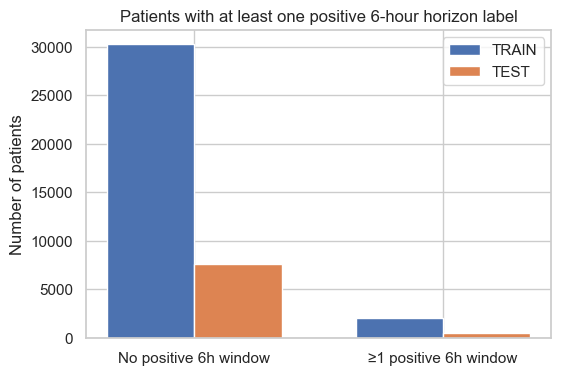

In [139]:
# Build patient-level 6h summaries for TEST (TRAIN already has patient_label_summary_train)
patient_label_summary_test = (
    test_df
    .groupby(PATIENT_COL)
    .agg(
        any_pos_6h=("Label_6h", "max"),
        has_sepsis=(TARGET_COL, "max"),
    )
    .reset_index()
)

# Ensure binary fields are integers
for df in (patient_label_summary_train, patient_label_summary_test):
    df["any_pos_6h"] = df["any_pos_6h"].astype(int)
    df["has_sepsis"] = df["has_sepsis"].astype(int)

counts_train = patient_label_summary_train["any_pos_6h"].value_counts().reindex([0, 1], fill_value=0)
counts_test = patient_label_summary_test["any_pos_6h"].value_counts().reindex([0, 1], fill_value=0)

labels = ["No positive 6h window", "≥1 positive 6h window"]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x - width / 2, counts_train.values, width, label="TRAIN")
ax.bar(x + width / 2, counts_test.values, width, label="TEST")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Number of patients")
ax.set_title("Patients with at least one positive 6-hour horizon label")
ax.legend()

EXPORTED_FIGURES.append(("02_patient_label6h_distribution_train_test", fig))
plt.show()


Only a small proportion of patients ever enter the 6-hour sepsis risk window.
In the training cohort, approximately 6% of patients have at least one positive
Label_6h. This reflects the clinical rarity of sepsis onset and explains why
the prediction task exhibits substantial class imbalance.


## Step 13 — Save labeled datasets for downstream notebooks


In [140]:
train_out_path = RESULTS_THIS / "02_labeling_eda_train.csv"
test_out_path = RESULTS_THIS / "02_labeling_eda_test.csv"
full_out_path = RESULTS_THIS / "02_labeling_eda_full.csv"

train_df.to_csv(train_out_path, index=False)
test_df.to_csv(test_out_path, index=False)
full_df.to_csv(full_out_path, index=False)

print("Saved labeled datasets:")
print("  train:", train_out_path)
print("  test :", test_out_path)
print("  full :", full_out_path)

Saved labeled datasets:
  train: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda\02_labeling_eda_train.csv
  test : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda\02_labeling_eda_test.csv
  full : C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\results\02_labeling_eda\02_labeling_eda_full.csv


## Step 14 — Export figures from EXPORTED_FIGURES


In [141]:
for name, fig in EXPORTED_FIGURES:
    out_path = FIGURES_THIS / f"{name}.png"
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print("Saved figure:", out_path)

print("\nAll figures exported.")

Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\02_labeling_eda\02_stay_length_hist.png
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\02_labeling_eda\02_onset_time_hist_train.png
Saved figure: C:\Users\marta\PyCharmMiscProject\sepsis-predictor\reports\figures\02_labeling_eda\02_patient_label6h_distribution_train_test.png

All figures exported.
